### Real Estate Property Cost Prediction Modelling

#### Overview
This notebook aims to analyze and predict real estate property costs using various machine learning models. The analysis includes model training, evaluation, and interpretation of results. The primary goal is to identify the key factors influencing property costs and build a robust predictive model.

#### Contents
1. **Data Loading and Preprocessing**:
    - Load the dataset and perform necessary preprocessing steps such as dropping features and scaling features.

2. **Feature Engineering and Selection**:
    - Create new features and select the most relevant ones using techniques like backward elimination and Lasso regression.

3. **Model Training and Evaluation**:
    - Train different machine learning models, including Linear Regression, Lasso Regression, and Gradient Boosting, and evaluate their performance using metrics like RMSE, MAE, and R².

4. **Feature Importance Analysis**:
    - Analyze the importance of different features in the predictive models to understand the key drivers of property costs.

5. **Model Comparison and Selection**:
    - Compare the performance of different models and select the best one based on evaluation metrics.

6. **Conclusion and Recommendations**:
    - Summarize the findings and provide recommendations for future work and potential improvements.

#### Key Findings
- **Linear Regression**: Provides a baseline model with reasonable performance.
- **Lasso Regression**: Performs feature selection by setting some coefficients to zero, simplifying the model.
- **Gradient Boosting**: Shows improved performance with an increasing number of trees, capturing more variance in the data.
- **Feature Importance**: Identifies key features such as the number of beds, baths, postal code, and travel distance to the CBD as significant predictors of property costs.

Produced with assistance from ChatGPT, powered by OpenAI.

In [76]:
from pyspark.sql import SparkSession, DataFrame
from pyspark.ml.feature import VectorAssembler, StandardScaler as SparkStandardScaler
from pyspark.ml.regression import LinearRegression, GBTRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.functions import col
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql import functions as F
import scipy.stats as stats


In [77]:
# Initialize Spark session
spark = (
    SparkSession.builder.appName("Melbourne Real Estate")
    .config("spark.sql.repl.eagerEval.enabled", True)
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .getOrCreate()
)

In [78]:
# Read the Parquet file into a Spark DataFrame
sdf = spark.read.parquet("../data/curated/prop_cleaned2.parquet")
sdf.printSchema()

root
 |-- postal_code: integer (nullable = true)
 |-- name: string (nullable = true)
 |-- property_url: string (nullable = true)
 |-- beds: integer (nullable = true)
 |-- baths: integer (nullable = true)
 |-- parkings: integer (nullable = true)
 |-- cost: integer (nullable = true)
 |-- built_in_wardrobes: integer (nullable = true)
 |-- dishwasher: integer (nullable = true)
 |-- air_conditioning: integer (nullable = true)
 |-- floorboards: integer (nullable = true)
 |-- secure_parking: integer (nullable = true)
 |-- intercom: integer (nullable = true)
 |-- heating: integer (nullable = true)
 |-- ensuite: integer (nullable = true)
 |-- balcony_deck: integer (nullable = true)
 |-- gym: integer (nullable = true)
 |-- furnished: integer (nullable = true)
 |-- close_to_shops: integer (nullable = true)
 |-- close_to_transport: integer (nullable = true)
 |-- fully_fenced: integer (nullable = true)
 |-- close_to_schools: integer (nullable = true)
 |-- ducted_heating: integer (nullable = true)
 

In [79]:
def shape(sdf: DataFrame) -> None:
    """
    Returns the shape of a Spark DataFrame as a tuple (number of rows, number of columns).
    """
    num_rows = sdf.count()
    num_columns = len(sdf.columns)
    print(f"Shape of the DataFrame: {num_rows} rows, {num_columns} columns.")

shape(sdf)

Shape of the DataFrame: 9621 rows, 206 columns.


In [80]:
sdf = sdf.drop('name', 'property_url', 'affordability_score', 'combined_score')

In [81]:
shape(sdf)

Shape of the DataFrame: 9621 rows, 202 columns.


In [82]:
# Get all the columns in sdf except 'cost', 'name' and 'property_url'
feature_columns = [col for col in sdf.columns if col not in ['cost']]

In [83]:
print(feature_columns)

['postal_code', 'beds', 'baths', 'parkings', 'built_in_wardrobes', 'dishwasher', 'air_conditioning', 'floorboards', 'secure_parking', 'intercom', 'heating', 'ensuite', 'balcony_deck', 'gym', 'furnished', 'close_to_shops', 'close_to_transport', 'fully_fenced', 'close_to_schools', 'ducted_heating', 'split_system_heating', 'swimming_pool', 'remote_garage', 'balcony', 'study', 'garden_courtyard', 'pets_allowed', 'internal_laundry', 'alarm_system', 'prop_type_index', 'parks_count', 'parks_average_travel_time_mins', 'parks_average_travel_distance_kms', 'parks_time_distance_product', 'schools_count', 'schools_average_travel_time_mins', 'schools_average_travel_distance_kms', 'schools_time_distance_product', 'supermarkets_count', 'supermarkets_average_travel_time_mins', 'supermarkets_average_travel_distance_kms', 'supermarkets_time_distance_product', 'hospitals_count', 'hospitals_average_travel_time_mins', 'hospitals_average_travel_distance_kms', 'hospitals_time_distance_product', 'shopping_dis

In [84]:
# Combine feature columns into a single vector column 'features'
assembler = VectorAssembler(inputCols=feature_columns, outputCol='features')

# Select target variable 'cost' and feature columns from DataFrame 'sdf'
data = sdf.select('cost', *feature_columns)

# Transform the DataFrame to add the 'features' column
data = assembler.transform(data)

# Display the transformed DataFrame
data.show()

+----+-----------+----+-----+--------+------------------+----------+----------------+-----------+--------------+--------+-------+-------+------------+---+---------+--------------+------------------+------------+----------------+--------------+--------------------+-------------+-------------+-------+-----+----------------+------------+----------------+------------+---------------+-----------+------------------------------+---------------------------------+---------------------------+-------------+--------------------------------+-----------------------------------+-----------------------------+------------------+-------------------------------------+----------------------------------------+----------------------------------+---------------+----------------------------------+-------------------------------------+-------------------------------+------------------------+-------------------------------------------+----------------------------------------------+------------------------------

In [85]:
# Create a StandardScaler instance
scaler = SparkStandardScaler(inputCol='features', outputCol='scaled_features', withMean=True, withStd=True)

# Fit the scaler to the data
scaler_model = scaler.fit(data)

# Transform the data using the fitted scaler
data = scaler_model.transform(data)

In [86]:
# Split the data into training and test sets
train_data, test_data = data.randomSplit([0.8, 0.2], seed = 1003)

In [87]:
# Initialize the Linear Regression model
lr = LinearRegression(featuresCol='scaled_features', labelCol='cost')

# Fit the model to the training data
lr_model = lr.fit(train_data)

24/10/17 22:23:05 WARN Instrumentation: [ec366713] regParam is zero, which might cause numerical instability and overfitting.
24/10/17 22:23:06 WARN Instrumentation: [ec366713] Cholesky solver failed due to singular covariance matrix. Retrying with Quasi-Newton solver.


In [92]:
# Save the Linear Regression model
lr_model.save("../models/linear_regression_model")

In [93]:
# Print model summary (Training Data)
print('BASE LINEAR REGRESSION MODEL SUMMARY')
print(f"Intercept: {round(lr_model.intercept, 3)}")
print(f"RMSE (Train): ${round(lr_model.summary.rootMeanSquaredError, 2)}")
print(f"R² (Train): {round(lr_model.summary.r2 * 100, 2)}%")

# Get feature coefficients and create DataFrame
coefficients = lr_model.coefficients.toArray()
coefficients_df = pd.DataFrame({
    'Feature': feature_columns,
    'Coefficient': [round(coeff, 3) for coeff in coefficients]
})

# Add absolute value for ranking and sort by impact
coefficients_df['Absolute Coefficient'] = abs(coefficients_df['Coefficient'])
coefficients_df = coefficients_df.sort_values(by='Absolute Coefficient', ascending=False)

# Evaluate model on test data
test_results = lr_model.evaluate(test_data)

# Print test data evaluation metrics
print("\nTest RMSE: ${:.2f}".format(test_results.rootMeanSquaredError))
print("Test R²: {:.2f}%".format(test_results.r2 * 100))

# Display top 10 features
coefficients_df.head(10)

BASE LINEAR REGRESSION MODEL SUMMARY
Intercept: 564.843
RMSE (Train): $73.43
R² (Train): 60.86%

Test RMSE: $72.22
Test R²: 60.22%


,Feature,Coefficient,Absolute Coefficient
196,increase_2021_pop,-87.321,87.321
1,beds,86.359,86.359
98,mar_2010,-64.447,64.447
52,cbd_average_travel_distance_kms,-64.421,64.421
193,increase_2018_pop,-52.796,52.796
181,increase_2006_pop,50.931,50.931
112,sep_2013,45.496,45.496
94,mar_2009,45.391,45.391
53,cbd_time_distance_product,42.613,42.613
191,increase_2016_pop,-40.682,40.682


### Analysis of the Baseline Linear Regression Model

#### Model Summary (Training Data)
The baseline linear regression model was trained on the dataset, and the following metrics were obtained for the training data:

- **Intercept**: 564.85
- **Root Mean Squared Error (RMSE)**: $73.42
- **R² (Coefficient of Determination)**: 60.87%

These metrics indicate that the model explains approximately 61.03% of the variance in the training data, with an average prediction error of $73.42.

#### Model Evaluation (Test Data)
The model was evaluated on the test data, yielding the following metrics:

- **Test RMSE**: $72.22
- **Test R²**: 60.23%

The test data metrics are quite similar to the training data metrics, suggesting that the model generalizes well to unseen data. The R² value of 60.23% indicates that the model explains a similar proportion of variance in the test data as it does in the training data.

#### Feature Importance
The table lists the top 10 features based on their absolute coefficient values, indicating their impact on the model's predictions.

#### Observations
1. **Population Increase**: Features related to population increase in various years (e.g., 2021, 2018, 2006, 2016) have significant coefficients, indicating that changes in population are strong predictors in the model.
2. **Number of Beds**: The number of beds in a property is also a significant predictor, with a positive coefficient of 86.236.
3. **Travel Distance and Time**: Features related to travel distance and time to the central business district (CBD) are important, with negative coefficients indicating that greater distances are associated with lower property values.
4. **Monthly Data**: Specific months (e.g., March 2010, September 2013, March 2009) also appear as significant features, suggesting that there may be seasonal or temporal effects influencing property values.

In [94]:
# Initialize the Lasso Regression model
lasso = LinearRegression(featuresCol='features', labelCol='cost', elasticNetParam=1, regParam=0.1)

# Fit the model to the data
lasso_model = lasso.fit(train_data)

In [95]:
# Save the Lasso Regression model
lasso_model.save("../models/lasso_regression_model")

In [96]:
# Print model summary with formatted output
print('LASSO REGRESSION MODEL SUMMARY')
print(f"Intercept: {round(lasso_model.intercept, 3)}")
print(f"RMSE (Train): ${round(lasso_model.summary.rootMeanSquaredError, 2)}")
print(f"R² (Train): {round(lasso_model.summary.r2 * 100, 2)}%")

# Get the coefficients and feature names
lasso_coefficients = lasso_model.coefficients.toArray()

# Create a DataFrame from the coefficients and feature names
lasso_coefficients_df = pd.DataFrame({
    'Feature': feature_columns,
    'Coefficient': [round(coeff, 3) for coeff in lasso_coefficients]
})

# Add a column for the absolute value of coefficients
lasso_coefficients_df['Absolute Coefficient'] = lasso_coefficients_df['Coefficient'].abs()

# Sort the DataFrame by the 'Absolute Coefficient' column in descending order
lasso_coefficients_df = lasso_coefficients_df.sort_values(by='Absolute Coefficient', ascending=False)

# Evaluate the model on the test data
lasso_test_results = lasso_model.evaluate(test_data)

# Print evaluation metrics for test data
print("\nLasso Test RMSE: ${:.2f}".format(lasso_test_results.rootMeanSquaredError))
print("Lasso Test R²: {:.2f}%".format(lasso_test_results.r2 * 100))

# Display the top 10 features based on their absolute impact
lasso_coefficients_df.head(10)

LASSO REGRESSION MODEL SUMMARY
Intercept: -24.106
RMSE (Train): $75.47
R² (Train): 58.66%

Lasso Test RMSE: $73.75
Lasso Test R²: 58.52%


,Feature,Coefficient,Absolute Coefficient
1,beds,80.958,80.958
2,baths,62.741,62.741
5,dishwasher,28.543,28.543
13,gym,19.518,19.518
24,study,15.637,15.637
7,floorboards,15.049,15.049
4,built_in_wardrobes,-14.115,14.115
36,schools_average_travel_distance_kms,-13.384,13.384
6,air_conditioning,10.875,10.875
25,garden_courtyard,10.600,10.600


In [97]:
# Count the number of features with coefficients equal to zero
num_zero_coefficients = (lasso_coefficients_df['Coefficient'] == 0).sum()

# Print the result
print(f"Number of features remaining in Lasso Model: {len(feature_columns) - num_zero_coefficients - 1} out of {len(feature_columns) - 1} initial columns.")

Number of features remaining in Lasso Model: 169 out of 200 initial columns.


### Analysis of Lasso Regression Model

#### Model Summary (Training Data)
The Lasso regression model was trained on the dataset, and the following metrics were obtained for the training data:

- **Intercept**: -24.106
- **Root Mean Squared Error (RMSE)**: $75.47
- **R² (Coefficient of Determination)**: 58.66%

These metrics indicate that the model explains approximately 58.66% of the variance in the training data, with an average prediction error of $75.47.

#### Model Evaluation (Test Data)
The model was evaluated on the test data, yielding the following metrics:

- **Test RMSE**: $73.75
- **Test R²**: 58.52%

The test data metrics are quite similar to the training data metrics, suggesting that the model generalizes well to unseen data. The R² value of 58.52% indicates that the model explains a similar proportion of variance in the test data as it does in the training data.

#### Feature Importance
The table lists the top 10 features based on their absolute coefficient values, indicating their impact on the model's predictions.

#### Feature Selection with Lasso Regression
Lasso regression includes a regularization term that can set some coefficients to zero, effectively removing those features from the model. This property makes Lasso regression useful for feature selection.

The number of remaining features is 169 features.

These results indicate that the Lasso regression model has effectively reduced the number of features by setting some coefficients to zero. This reduction in the number of features can help in simplifying the model and potentially improving its interpretability and generalization to new data.

In [98]:
def backward_elimination(data: DataFrame, features: list, label: str, stop_threshold=0.1):
    features_to_keep = features.copy()
    
    while len(features_to_keep) > 0:
        print(f"Training model with {len(features_to_keep)} features.")
        
        # Assemble the feature vector for the current set of features
        assembler = VectorAssembler(inputCols=features_to_keep, outputCol="features")
        
        # Drop the existing 'features' column if it exists
        if 'features' in data.columns:
            data = data.drop('features')

        # Transform the data to create the new 'features' column
        data_assembled = assembler.transform(data).select("features", label)
        
        # Create a StandardScaler instance
        scaler = SparkStandardScaler(inputCol='features', outputCol='scaled_features', withMean=True, withStd=True)
        
        # Fit the scaler to the data and transform it
        scaler_model = scaler.fit(data_assembled)
        data_scaled = scaler_model.transform(data_assembled)
        
        # Train the model on the scaled features
        lr = LinearRegression(featuresCol="scaled_features", labelCol=label)
        lr_model = lr.fit(data_scaled)
        
        # Get the coefficients and associated features
        coefficients = lr_model.coefficients
        coef_feature_pairs = list(zip(coefficients, features_to_keep))
        
        # Find the least significant feature (smallest coefficient magnitude)
        least_significant_feature = min(coef_feature_pairs, key=lambda x: abs(x[0]))[1]
        
        # Check the magnitude of the smallest coefficient using absolute value
        if abs(min(coef_feature_pairs, key=lambda x: abs(x[0]))[0]) < stop_threshold:
            print(f"Removing least significant feature: {least_significant_feature}")
            features_to_keep.remove(least_significant_feature)
        else:
            break

    print(f"Final set of features: {features_to_keep}")
    return features_to_keep

In [46]:
# Perform backward elimination
final_features = backward_elimination(data, feature_columns, 'cost', stop_threshold=13)

Training model with 201 features.


24/10/17 21:46:21 WARN Instrumentation: [818808c1] regParam is zero, which might cause numerical instability and overfitting.
24/10/17 21:46:22 WARN Instrumentation: [818808c1] Cholesky solver failed due to singular covariance matrix. Retrying with Quasi-Newton solver.


Removing least significant feature: cbd_count
Training model with 200 features.


24/10/17 21:46:25 WARN Instrumentation: [a9532c08] regParam is zero, which might cause numerical instability and overfitting.
24/10/17 21:46:26 WARN Instrumentation: [a9532c08] Cholesky solver failed due to singular covariance matrix. Retrying with Quasi-Newton solver.


Removing least significant feature: close_to_shops
Training model with 199 features.


24/10/17 21:46:27 WARN Instrumentation: [500c63f3] regParam is zero, which might cause numerical instability and overfitting.
24/10/17 21:46:28 WARN Instrumentation: [500c63f3] Cholesky solver failed due to singular covariance matrix. Retrying with Quasi-Newton solver.


Removing least significant feature: alarm_system
Training model with 198 features.


24/10/17 21:46:30 WARN Instrumentation: [d0963544] regParam is zero, which might cause numerical instability and overfitting.
24/10/17 21:46:30 WARN Instrumentation: [d0963544] Cholesky solver failed due to singular covariance matrix. Retrying with Quasi-Newton solver.


Removing least significant feature: intercom
Training model with 197 features.


24/10/17 21:46:32 WARN Instrumentation: [47b6982a] regParam is zero, which might cause numerical instability and overfitting.
24/10/17 21:46:33 WARN Instrumentation: [47b6982a] Cholesky solver failed due to singular covariance matrix. Retrying with Quasi-Newton solver.


Removing least significant feature: internal_laundry
Training model with 196 features.


24/10/17 21:46:35 WARN Instrumentation: [9d050bb0] regParam is zero, which might cause numerical instability and overfitting.
24/10/17 21:46:36 WARN Instrumentation: [9d050bb0] Cholesky solver failed due to singular covariance matrix. Retrying with Quasi-Newton solver.


Removing least significant feature: remote_garage
Training model with 195 features.


24/10/17 21:46:38 WARN Instrumentation: [dedbb0bf] regParam is zero, which might cause numerical instability and overfitting.
24/10/17 21:46:39 WARN Instrumentation: [dedbb0bf] Cholesky solver failed due to singular covariance matrix. Retrying with Quasi-Newton solver.


Removing least significant feature: close_to_schools
Training model with 194 features.


24/10/17 21:46:40 WARN Instrumentation: [a4279225] regParam is zero, which might cause numerical instability and overfitting.
24/10/17 21:46:41 WARN Instrumentation: [a4279225] Cholesky solver failed due to singular covariance matrix. Retrying with Quasi-Newton solver.


Removing least significant feature: dec_2017
Training model with 193 features.


24/10/17 21:46:42 WARN Instrumentation: [32082358] regParam is zero, which might cause numerical instability and overfitting.
24/10/17 21:46:43 WARN Instrumentation: [32082358] Cholesky solver failed due to singular covariance matrix. Retrying with Quasi-Newton solver.


Removing least significant feature: dec_2016
Training model with 192 features.


24/10/17 21:46:44 WARN Instrumentation: [d841efaa] regParam is zero, which might cause numerical instability and overfitting.
24/10/17 21:46:45 WARN Instrumentation: [d841efaa] Cholesky solver failed due to singular covariance matrix. Retrying with Quasi-Newton solver.


Removing least significant feature: split_system_heating
Training model with 191 features.


24/10/17 21:46:47 WARN Instrumentation: [99b9179a] regParam is zero, which might cause numerical instability and overfitting.
24/10/17 21:46:48 WARN Instrumentation: [99b9179a] Cholesky solver failed due to singular covariance matrix. Retrying with Quasi-Newton solver.


Removing least significant feature: ducted_heating
Training model with 190 features.


24/10/17 21:46:50 WARN Instrumentation: [85bc5b1e] regParam is zero, which might cause numerical instability and overfitting.
24/10/17 21:46:51 WARN Instrumentation: [85bc5b1e] Cholesky solver failed due to singular covariance matrix. Retrying with Quasi-Newton solver.


Removing least significant feature: 2005_pop
Training model with 189 features.


24/10/17 21:46:53 WARN Instrumentation: [c990b3c1] regParam is zero, which might cause numerical instability and overfitting.
24/10/17 21:46:53 WARN Instrumentation: [c990b3c1] Cholesky solver failed due to singular covariance matrix. Retrying with Quasi-Newton solver.


Removing least significant feature: jun_2022
Training model with 188 features.


24/10/17 21:46:56 WARN Instrumentation: [da390224] regParam is zero, which might cause numerical instability and overfitting.
24/10/17 21:46:57 WARN Instrumentation: [da390224] Cholesky solver failed due to singular covariance matrix. Retrying with Quasi-Newton solver.


Removing least significant feature: ensuite
Training model with 187 features.


24/10/17 21:47:01 WARN Instrumentation: [30dca089] regParam is zero, which might cause numerical instability and overfitting.
24/10/17 21:47:02 WARN Instrumentation: [30dca089] Cholesky solver failed due to singular covariance matrix. Retrying with Quasi-Newton solver.


Removing least significant feature: heating
Training model with 186 features.


24/10/17 21:47:05 WARN Instrumentation: [8074725e] regParam is zero, which might cause numerical instability and overfitting.
24/10/17 21:47:06 WARN Instrumentation: [8074725e] Cholesky solver failed due to singular covariance matrix. Retrying with Quasi-Newton solver.


Removing least significant feature: train_stations_time_distance_product
Training model with 185 features.


24/10/17 21:47:08 WARN Instrumentation: [18088cd3] regParam is zero, which might cause numerical instability and overfitting.
24/10/17 21:47:09 WARN Instrumentation: [18088cd3] Cholesky solver failed due to singular covariance matrix. Retrying with Quasi-Newton solver.


Removing least significant feature: parks_count
Training model with 184 features.


24/10/17 21:47:11 WARN Instrumentation: [23138da3] regParam is zero, which might cause numerical instability and overfitting.
24/10/17 21:47:12 WARN Instrumentation: [23138da3] Cholesky solver failed due to singular covariance matrix. Retrying with Quasi-Newton solver.


Removing least significant feature: fully_fenced
Training model with 183 features.


24/10/17 21:47:14 WARN Instrumentation: [d192c35f] regParam is zero, which might cause numerical instability and overfitting.
24/10/17 21:47:15 WARN Instrumentation: [d192c35f] Cholesky solver failed due to singular covariance matrix. Retrying with Quasi-Newton solver.


Removing least significant feature: prop_type_index
Training model with 182 features.


24/10/17 21:47:16 WARN Instrumentation: [ecb98d08] regParam is zero, which might cause numerical instability and overfitting.
24/10/17 21:47:17 WARN Instrumentation: [ecb98d08] Cholesky solver failed due to singular covariance matrix. Retrying with Quasi-Newton solver.


Removing least significant feature: close_to_transport
Training model with 181 features.


24/10/17 21:47:19 WARN Instrumentation: [aa98787d] regParam is zero, which might cause numerical instability and overfitting.
24/10/17 21:47:20 WARN Instrumentation: [aa98787d] Cholesky solver failed due to singular covariance matrix. Retrying with Quasi-Newton solver.


Removing least significant feature: dec_2021
Training model with 180 features.


24/10/17 21:47:21 WARN Instrumentation: [c7fbb049] regParam is zero, which might cause numerical instability and overfitting.
24/10/17 21:47:22 WARN Instrumentation: [c7fbb049] Cholesky solver failed due to singular covariance matrix. Retrying with Quasi-Newton solver.


Removing least significant feature: garden_courtyard
Training model with 179 features.


24/10/17 21:47:24 WARN Instrumentation: [03a085e1] regParam is zero, which might cause numerical instability and overfitting.
24/10/17 21:47:25 WARN Instrumentation: [03a085e1] Cholesky solver failed due to singular covariance matrix. Retrying with Quasi-Newton solver.


Removing least significant feature: parkings
Training model with 178 features.


24/10/17 21:47:26 WARN Instrumentation: [747e6525] regParam is zero, which might cause numerical instability and overfitting.
24/10/17 21:47:27 WARN Instrumentation: [747e6525] Cholesky solver failed due to singular covariance matrix. Retrying with Quasi-Newton solver.


Removing least significant feature: balcony_deck
Training model with 177 features.


24/10/17 21:47:29 WARN Instrumentation: [5ecf0984] regParam is zero, which might cause numerical instability and overfitting.
24/10/17 21:47:29 WARN Instrumentation: [5ecf0984] Cholesky solver failed due to singular covariance matrix. Retrying with Quasi-Newton solver.


Removing least significant feature: jun_2000
Training model with 176 features.


24/10/17 21:47:31 WARN Instrumentation: [6be9433f] regParam is zero, which might cause numerical instability and overfitting.
24/10/17 21:47:31 WARN Instrumentation: [6be9433f] Cholesky solver failed due to singular covariance matrix. Retrying with Quasi-Newton solver.


Removing least significant feature: increase_2002_pop
Training model with 175 features.


24/10/17 21:47:33 WARN Instrumentation: [af49b083] regParam is zero, which might cause numerical instability and overfitting.


Removing least significant feature: supermarkets_count
Training model with 174 features.


24/10/17 21:47:35 WARN Instrumentation: [1328eae6] regParam is zero, which might cause numerical instability and overfitting.


Removing least significant feature: parks_time_distance_product
Training model with 173 features.


24/10/17 21:47:38 WARN Instrumentation: [99a8a4e2] regParam is zero, which might cause numerical instability and overfitting.


Removing least significant feature: jun_2015
Training model with 172 features.


24/10/17 21:47:40 WARN Instrumentation: [5940c0f1] regParam is zero, which might cause numerical instability and overfitting.


Removing least significant feature: cbd_average_travel_time_mins
Training model with 171 features.


24/10/17 21:47:42 WARN Instrumentation: [9fbe0f76] regParam is zero, which might cause numerical instability and overfitting.


Removing least significant feature: normalized_livability_score
Training model with 170 features.


24/10/17 21:47:45 WARN Instrumentation: [3e76fa54] regParam is zero, which might cause numerical instability and overfitting.


Removing least significant feature: balcony
Training model with 169 features.


24/10/17 21:47:47 WARN Instrumentation: [58d83da6] regParam is zero, which might cause numerical instability and overfitting.


Removing least significant feature: secure_parking
Training model with 168 features.


24/10/17 21:47:49 WARN Instrumentation: [64fc8444] regParam is zero, which might cause numerical instability and overfitting.


Removing least significant feature: hospitals_average_travel_time_mins
Training model with 167 features.


24/10/17 21:47:50 WARN Instrumentation: [be254dc4] regParam is zero, which might cause numerical instability and overfitting.


Removing least significant feature: train_stations_count
Training model with 166 features.


24/10/17 21:47:53 WARN Instrumentation: [d042b576] regParam is zero, which might cause numerical instability and overfitting.


Removing least significant feature: train_stations_average_travel_time_mins
Training model with 165 features.


24/10/17 21:47:55 WARN Instrumentation: [93acccdf] regParam is zero, which might cause numerical instability and overfitting.


Removing least significant feature: train_stations_average_travel_distance_kms
Training model with 164 features.


24/10/17 21:47:57 WARN Instrumentation: [0838d70c] regParam is zero, which might cause numerical instability and overfitting.


Removing least significant feature: sep_2018
Training model with 163 features.


24/10/17 21:47:59 WARN Instrumentation: [c2197e47] regParam is zero, which might cause numerical instability and overfitting.


Removing least significant feature: furnished
Training model with 162 features.


24/10/17 21:48:01 WARN Instrumentation: [16fe6307] regParam is zero, which might cause numerical instability and overfitting.


Removing least significant feature: schools_average_travel_distance_kms
Training model with 161 features.


24/10/17 21:48:03 WARN Instrumentation: [7805df27] regParam is zero, which might cause numerical instability and overfitting.


Removing least significant feature: shopping_districts_count
Training model with 160 features.


24/10/17 21:48:05 WARN Instrumentation: [13c88bcf] regParam is zero, which might cause numerical instability and overfitting.


Removing least significant feature: pets_allowed
Training model with 159 features.


24/10/17 21:48:07 WARN Instrumentation: [7749d1e8] regParam is zero, which might cause numerical instability and overfitting.


Removing least significant feature: schools_count
Training model with 158 features.


24/10/17 21:48:09 WARN Instrumentation: [dc63172e] regParam is zero, which might cause numerical instability and overfitting.


Removing least significant feature: study
Training model with 157 features.


24/10/17 21:48:11 WARN Instrumentation: [b88f6204] regParam is zero, which might cause numerical instability and overfitting.


Removing least significant feature: sep_2015
Training model with 156 features.


24/10/17 21:48:13 WARN Instrumentation: [e6c4fef8] regParam is zero, which might cause numerical instability and overfitting.


Removing least significant feature: 2003_pop
Training model with 155 features.


24/10/17 21:48:15 WARN Instrumentation: [81749f18] regParam is zero, which might cause numerical instability and overfitting.


Removing least significant feature: swimming_pool
Training model with 154 features.


24/10/17 21:48:17 WARN Instrumentation: [32fe9298] regParam is zero, which might cause numerical instability and overfitting.


Removing least significant feature: floorboards
Training model with 153 features.


24/10/17 21:48:19 WARN Instrumentation: [5969b68c] regParam is zero, which might cause numerical instability and overfitting.


Removing least significant feature: sep_2008
Training model with 152 features.


24/10/17 21:48:21 WARN Instrumentation: [ac8ea0d8] regParam is zero, which might cause numerical instability and overfitting.


Removing least significant feature: built_in_wardrobes
Training model with 151 features.


24/10/17 21:48:24 WARN Instrumentation: [184629fd] regParam is zero, which might cause numerical instability and overfitting.


Removing least significant feature: air_conditioning
Training model with 150 features.


24/10/17 21:48:25 WARN Instrumentation: [0825ca24] regParam is zero, which might cause numerical instability and overfitting.


Removing least significant feature: parks_average_travel_time_mins
Training model with 149 features.


24/10/17 21:48:27 WARN Instrumentation: [4455cbaf] regParam is zero, which might cause numerical instability and overfitting.


Removing least significant feature: parks_average_travel_distance_kms
Training model with 148 features.


24/10/17 21:48:29 WARN Instrumentation: [607ea922] regParam is zero, which might cause numerical instability and overfitting.


Removing least significant feature: gym
Training model with 147 features.


24/10/17 21:48:32 WARN Instrumentation: [640cbf68] regParam is zero, which might cause numerical instability and overfitting.


Removing least significant feature: hospitals_average_travel_distance_kms
Training model with 146 features.


24/10/17 21:48:33 WARN Instrumentation: [ff7cdc4f] regParam is zero, which might cause numerical instability and overfitting.


Removing least significant feature: hospitals_time_distance_product
Training model with 145 features.


24/10/17 21:48:35 WARN Instrumentation: [236d82a0] regParam is zero, which might cause numerical instability and overfitting.


Removing least significant feature: sep_2016
Training model with 144 features.


24/10/17 21:48:37 WARN Instrumentation: [55a650e7] regParam is zero, which might cause numerical instability and overfitting.


Removing least significant feature: hospitals_count
Training model with 143 features.


24/10/17 21:48:39 WARN Instrumentation: [acd8d71f] regParam is zero, which might cause numerical instability and overfitting.


Removing least significant feature: jun_2003
Training model with 142 features.


24/10/17 21:48:41 WARN Instrumentation: [203751f1] regParam is zero, which might cause numerical instability and overfitting.


Removing least significant feature: mar_2009
Training model with 141 features.


24/10/17 21:48:43 WARN Instrumentation: [3b271d1c] regParam is zero, which might cause numerical instability and overfitting.


Removing least significant feature: schools_average_travel_time_mins
Training model with 140 features.


24/10/17 21:48:44 WARN Instrumentation: [a982268f] regParam is zero, which might cause numerical instability and overfitting.


Removing least significant feature: schools_time_distance_product
Training model with 139 features.


24/10/17 21:48:46 WARN Instrumentation: [a9af6068] regParam is zero, which might cause numerical instability and overfitting.


Removing least significant feature: postal_code
Training model with 138 features.


24/10/17 21:48:48 WARN Instrumentation: [0fc61fe6] regParam is zero, which might cause numerical instability and overfitting.


Removing least significant feature: dec_2020
Training model with 137 features.


24/10/17 21:48:50 WARN Instrumentation: [62607861] regParam is zero, which might cause numerical instability and overfitting.


Removing least significant feature: increase_2017_pop
Training model with 136 features.


24/10/17 21:48:52 WARN Instrumentation: [95833b4f] regParam is zero, which might cause numerical instability and overfitting.


Final set of features: ['beds', 'baths', 'dishwasher', 'supermarkets_average_travel_time_mins', 'supermarkets_average_travel_distance_kms', 'supermarkets_time_distance_product', 'shopping_districts_average_travel_time_mins', 'shopping_districts_average_travel_distance_kms', 'shopping_districts_time_distance_product', 'cbd_average_travel_distance_kms', 'cbd_time_distance_product', 'mar_2000', 'sep_2000', 'dec_2000', 'mar_2001', 'jun_2001', 'sep_2001', 'dec_2001', 'mar_2002', 'jun_2002', 'sep_2002', 'dec_2002', 'mar_2003', 'sep_2003', 'dec_2003', 'mar_2004', 'jun_2004', 'sep_2004', 'dec_2004', 'mar_2005', 'jun_2005', 'sep_2005', 'dec_2005', 'mar_2006', 'jun_2006', 'sep_2006', 'dec_2006', 'mar_2007', 'jun_2007', 'sep_2007', 'dec_2007', 'mar_2008', 'jun_2008', 'dec_2008', 'jun_2009', 'sep_2009', 'dec_2009', 'mar_2010', 'jun_2010', 'sep_2010', 'dec_2010', 'mar_2011', 'jun_2011', 'sep_2011', 'dec_2011', 'mar_2012', 'jun_2012', 'sep_2012', 'dec_2012', 'mar_2013', 'jun_2013', 'sep_2013', 'dec_

In [99]:
# Combine final feature columns into a single vector column 'features'
assembler = VectorAssembler(inputCols=final_features, outputCol='features')

# Select target variable 'cost' and final feature columns from DataFrame 'sdf'
data = sdf.select('cost', *final_features)

# Transform the DataFrame to add the 'features' column
data = assembler.transform(data)

In [100]:
# Create a StandardScaler instance
scaler = SparkStandardScaler(inputCol='features', outputCol='scaled_features', withMean=True, withStd=True)

# Fit the scaler to the data
scaler_model = scaler.fit(data)

# Transform the data using the fitted scaler
data = scaler_model.transform(data)

In [101]:
train_data, test_data = data.randomSplit([0.8, 0.2], seed=1003)

In [102]:
# Initialize the Linear Regression model
bw = LinearRegression(featuresCol='scaled_features', labelCol='cost')

# Fit the model to the training data
bw_model = lr.fit(train_data)

24/10/17 22:25:34 WARN Instrumentation: [9354b549] regParam is zero, which might cause numerical instability and overfitting.


In [104]:
# Save the Backward Elimination model
bw_model.save("../models/backward_elimination_model")

In [103]:
# Print model summary with formatted output for the Backwards Elimination Linear Regression model
print("BACKWARDS ELIMINATION MODEL SUMMARY")
print(f"Intercept: {round(bw_model.intercept, 3)}")  # Display the intercept value, rounded to 3 decimal places
print(f"RMSE (Train): ${round(bw_model.summary.rootMeanSquaredError, 2)}")  # Root Mean Squared Error for training set, formatted as a dollar value
print(f"R² (Train): {round(bw_model.summary.r2 * 100, 2)}%")  # Coefficient of determination (R²) for training set in percentage

# Get the coefficients and feature names
coefficients = bw_model.coefficients.toArray()  # Convert coefficients into a numpy array
feature_names = final_features  # Assume 'final_features' contains the selected feature names after backward elimination

# Create a DataFrame to store features, their coefficients, and absolute coefficient values
coefficients_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': [round(coeff, 3) for coeff in coefficients]  # Round coefficients to 3 decimal places for readability
})

# Calculate the absolute value of each coefficient to determine feature importance
coefficients_df['Absolute Coefficient'] = coefficients_df['Coefficient'].abs()

# Sort the DataFrame by 'Absolute Coefficient' in descending order for feature importance
coefficients_df = coefficients_df.sort_values(by='Absolute Coefficient', ascending=False)

# Evaluate the model on the test data to get the evaluation metrics
test_results = bw_model.evaluate(test_data)

# Print evaluation metrics for the test data
print("\nLINEAR REGRESSION MODEL EVALUATION (Test Data)")
print(f"RMSE (Test): ${round(test_results.rootMeanSquaredError, 2)}")  # Root Mean Squared Error for the test set, formatted as a dollar value
print(f"R² (Test): {round(test_results.r2 * 100, 2)}%")  # Coefficient of determination (R²) for test set in percentage

# Display the top 10 features ranked by their absolute impact on the model
print("\nTOP 10 MOST IMPACTFUL FEATURES")
coefficients_df.head(10)  # Display the top 10 most impactful features by absolute coefficient value

BACKWARDS ELIMINATION MODEL SUMMARY
Intercept: 564.378
RMSE (Train): $72.26
R² (Train): 62.1%

LINEAR REGRESSION MODEL EVALUATION (Test Data)
RMSE (Test): $71.35
R² (Test): 61.17%

TOP 10 MOST IMPACTFUL FEATURES


,Feature,Coefficient,Absolute Coefficient
114,pop_growth,13028.168,13028.168
104,2014_pop,8169.137,8169.137
100,2010_pop,-7492.900,7492.900
133,increase_2022_pop,-7231.159,7231.159
134,increase_2023_pop,-6279.662,6279.662
97,2007_pop,-5966.277,5966.277
103,2013_pop,-5624.353,5624.353
105,2015_pop,-5263.096,5263.096
109,2019_pop,-5045.422,5045.422
99,2009_pop,5002.188,5002.188


### Analysis of Backwards Elimination Model

#### Model Summary (Training Data)
The backwards elimination model was trained on the dataset, and the following metrics were obtained for the training data:

- **Intercept**: 564.378
- **Root Mean Squared Error (RMSE)**: $72.26
- **R² (Coefficient of Determination)**: 62.1%

These metrics indicate that the model explains approximately 62.1% of the variance in the training data, with an average prediction error of $72.26.

#### Model Evaluation (Test Data)
The model was evaluated on the test data, yielding the following metrics:

- **RMSE (Test)**: $71.35
- **R² (Test)**: 61.17%

The test data metrics are quite similar to the training data metrics, suggesting that the model generalizes well to unseen data. The R² value of 61.17% indicates that the model explains a similar proportion of variance in the test data as it does in the training data.

#### Top 10 Most Impactful Features
The table lists the top 10 features based on their absolute coefficient values, indicating their impact on the model's predictions.

#### Observations
1. **Population Growth**: The feature `pop_growth` has the highest positive coefficient, indicating a strong positive impact on the target variable.
2. **Yearly Population Data**: Features related to population in specific years (e.g., 2014, 2010, 2007, 2013, 2015, 2019, 2009) have significant coefficients, suggesting that historical population data is a strong predictor in the model.
3. **Population Increase**: Features related to population increase in recent years (e.g., 2022, 2023) have significant negative coefficients, indicating their impact on the target variable.

In [105]:
# Transform the test data and convert to Pandas DataFrame for visualization
# Combine actual 'cost' and predicted values into a single DataFrame directly
comparison_df = lr_model.transform(test_data).select('cost', 'prediction').toPandas()

# Scatter plot to check linearity between actual cost and predicted values
plt.figure(figsize=(10, 6))  # Set a better figure size
sns.regplot(x='cost', y='prediction', data=comparison_df, scatter_kws={"alpha": 0.5}, line_kws={"color": "red"})

# Adding labels and title
plt.xlabel('Actual Cost', fontsize=12)
plt.ylabel('Predicted Cost', fontsize=12)
plt.title('Actual vs Predicted Cost: Linearity Check', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)  # Adding grid for better readability

plt.show()

24/10/17 22:26:16 ERROR Executor: Exception in task 3.0 in stage 42.0 (TID 85)
org.apache.spark.SparkException: [FAILED_EXECUTE_UDF] Failed to execute user defined function (`PredictionModel$$Lambda$4028/1173133754`: (struct<type:tinyint,size:int,indices:array<int>,values:array<double>>) => double).
	at org.apache.spark.sql.errors.QueryExecutionErrors$.failedExecuteUserDefinedFunctionError(QueryExecutionErrors.scala:198)
	at org.apache.spark.sql.errors.QueryExecutionErrors.failedExecuteUserDefinedFunctionError(QueryExecutionErrors.scala)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenEvaluatorFactory$WholeStageCodegenPartitionEvaluator$$anon$1.hasNext(WholeStageCodegenEvaluatorFactory.scala:43)
	at org.apache.spark.sql.execution.SparkPlan.$anonfun$getByteArrayRdd$1(Spar

Py4JJavaError: An error occurred while calling o23185.collectToPython.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 2 in stage 42.0 failed 1 times, most recent failure: Lost task 2.0 in stage 42.0 (TID 84) (192.168.20.213 executor driver): org.apache.spark.SparkException: [FAILED_EXECUTE_UDF] Failed to execute user defined function (`PredictionModel$$Lambda$4028/1173133754`: (struct<type:tinyint,size:int,indices:array<int>,values:array<double>>) => double).
	at org.apache.spark.sql.errors.QueryExecutionErrors$.failedExecuteUserDefinedFunctionError(QueryExecutionErrors.scala:198)
	at org.apache.spark.sql.errors.QueryExecutionErrors.failedExecuteUserDefinedFunctionError(QueryExecutionErrors.scala)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenEvaluatorFactory$WholeStageCodegenPartitionEvaluator$$anon$1.hasNext(WholeStageCodegenEvaluatorFactory.scala:43)
	at org.apache.spark.sql.execution.SparkPlan.$anonfun$getByteArrayRdd$1(SparkPlan.scala:388)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitionsInternal$2(RDD.scala:893)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitionsInternal$2$adapted(RDD.scala:893)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:93)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:166)
	at org.apache.spark.scheduler.Task.run(Task.scala:141)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$4(Executor.scala:620)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:64)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:61)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:94)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:623)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	at java.lang.Thread.run(Thread.java:750)
Caused by: java.lang.IllegalArgumentException: requirement failed: BLAS.dot(x: Vector, y:Vector) was given Vectors with non-matching sizes: x.size = 136, y.size = 201
	at scala.Predef$.require(Predef.scala:281)
	at org.apache.spark.ml.linalg.BLAS$.dot(BLAS.scala:123)
	at org.apache.spark.ml.regression.LinearRegressionModel.predict(LinearRegression.scala:746)
	at org.apache.spark.ml.regression.LinearRegressionModel.predict(LinearRegression.scala:696)
	at org.apache.spark.ml.PredictionModel.$anonfun$transformImpl$1(Predictor.scala:204)
	at org.apache.spark.ml.PredictionModel.$anonfun$transformImpl$1$adapted(Predictor.scala:203)
	... 20 more

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2856)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2792)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2791)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2791)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1247)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1247)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1247)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:3060)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2994)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2983)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:989)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2398)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2419)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2438)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2463)
	at org.apache.spark.rdd.RDD.$anonfun$collect$1(RDD.scala:1049)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:410)
	at org.apache.spark.rdd.RDD.collect(RDD.scala:1048)
	at org.apache.spark.sql.execution.SparkPlan.executeCollect(SparkPlan.scala:448)
	at org.apache.spark.sql.Dataset.$anonfun$collectToPython$1(Dataset.scala:4148)
	at org.apache.spark.sql.Dataset.$anonfun$withAction$2(Dataset.scala:4322)
	at org.apache.spark.sql.execution.QueryExecution$.withInternalError(QueryExecution.scala:546)
	at org.apache.spark.sql.Dataset.$anonfun$withAction$1(Dataset.scala:4320)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$6(SQLExecution.scala:125)
	at org.apache.spark.sql.execution.SQLExecution$.withSQLConfPropagated(SQLExecution.scala:201)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$1(SQLExecution.scala:108)
	at org.apache.spark.sql.SparkSession.withActive(SparkSession.scala:900)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId(SQLExecution.scala:66)
	at org.apache.spark.sql.Dataset.withAction(Dataset.scala:4320)
	at org.apache.spark.sql.Dataset.collectToPython(Dataset.scala:4145)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.lang.Thread.run(Thread.java:750)
Caused by: org.apache.spark.SparkException: [FAILED_EXECUTE_UDF] Failed to execute user defined function (`PredictionModel$$Lambda$4028/1173133754`: (struct<type:tinyint,size:int,indices:array<int>,values:array<double>>) => double).
	at org.apache.spark.sql.errors.QueryExecutionErrors$.failedExecuteUserDefinedFunctionError(QueryExecutionErrors.scala:198)
	at org.apache.spark.sql.errors.QueryExecutionErrors.failedExecuteUserDefinedFunctionError(QueryExecutionErrors.scala)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenEvaluatorFactory$WholeStageCodegenPartitionEvaluator$$anon$1.hasNext(WholeStageCodegenEvaluatorFactory.scala:43)
	at org.apache.spark.sql.execution.SparkPlan.$anonfun$getByteArrayRdd$1(SparkPlan.scala:388)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitionsInternal$2(RDD.scala:893)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitionsInternal$2$adapted(RDD.scala:893)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:93)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:166)
	at org.apache.spark.scheduler.Task.run(Task.scala:141)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$4(Executor.scala:620)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:64)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:61)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:94)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:623)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	... 1 more
Caused by: java.lang.IllegalArgumentException: requirement failed: BLAS.dot(x: Vector, y:Vector) was given Vectors with non-matching sizes: x.size = 136, y.size = 201
	at scala.Predef$.require(Predef.scala:281)
	at org.apache.spark.ml.linalg.BLAS$.dot(BLAS.scala:123)
	at org.apache.spark.ml.regression.LinearRegressionModel.predict(LinearRegression.scala:746)
	at org.apache.spark.ml.regression.LinearRegressionModel.predict(LinearRegression.scala:696)
	at org.apache.spark.ml.PredictionModel.$anonfun$transformImpl$1(Predictor.scala:204)
	at org.apache.spark.ml.PredictionModel.$anonfun$transformImpl$1$adapted(Predictor.scala:203)
	... 20 more


### Analysis of Actual vs Predicted Cost: Linearity Check

This scatter plot shows the relationship between actual cost (x-axis) and predicted cost (y-axis). The red line representing the line of best fit has been added to help assess the linearity between these two variables.

### Observations:
1. **General Trend**: The points generally follow a positive trend, meaning as the actual cost increases, the predicted cost tends to increase as well. This suggests that the model is somewhat successful in predicting the cost, but there are a few areas where the fit is less accurate.
   
2. **Deviation from Linearity**: 
    - There is some noticeable deviation from the line of best fit. For lower actual cost values (below 400), the spread of predicted cost is quite wide, suggesting that the model has more prediction uncertainty in this range.
    - For higher actual cost values (above 600), although the general trend remains upward, there seems to be a cluster of points with larger spread, which suggests heteroscedasticity (increasing variance in residuals).

3. **Underestimation and Overestimation**:
    - For actual costs lower than 300, the model tends to overestimate the predicted costs, as many points lie above the red line.
    - For actual costs greater than 700, the model tends to underestimate, as points are often below the line.
  
4. **Potential Non-linearity**: 
    - The increasing spread of points for higher actual costs indicates the possibility of a non-linear relationship, which the linear model may not be capturing well.
    - The presence of some outliers, especially in the lower and upper actual cost ranges, could be affecting the model’s performance.

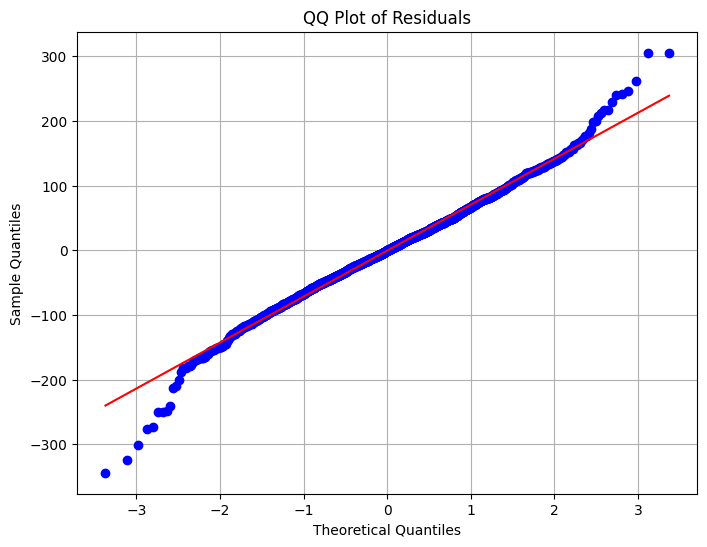

In [54]:
# Get actual and predicted costs
actual_cost = test_data.select('cost').toPandas()
predictions = lr_model.transform(test_data).select('prediction').toPandas()

# Calculate residuals
residuals = actual_cost['cost'] - predictions['prediction']

# Create a QQ plot
plt.figure(figsize=(8, 6))
stats.probplot(residuals, dist="norm", plot=plt)
plt.title('QQ Plot of Residuals')
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Sample Quantiles')  
plt.grid()
plt.show()

### Analysis of QQ Plot of Residuals

This QQ plot compares the sample quantiles of the residuals (y-axis) with the theoretical quantiles from a normal distribution (x-axis).

### Observations:
1. **Linearity**: 
    - Most points lie close to the red line, indicating that the residuals approximately follow a normal distribution.
   
2. **Deviations in Tails**:
    - At both extremes (left tail < -2 and right tail > 2), there are notable deviations from the red line. This suggests that the residuals exhibit **heavy tails**, implying potential outliers or non-normality in the residual distribution.
  
3. **Potential Outliers**:
    - The points at the extreme ends suggest that there might be a few outliers that could affect the model's assumptions of normality.

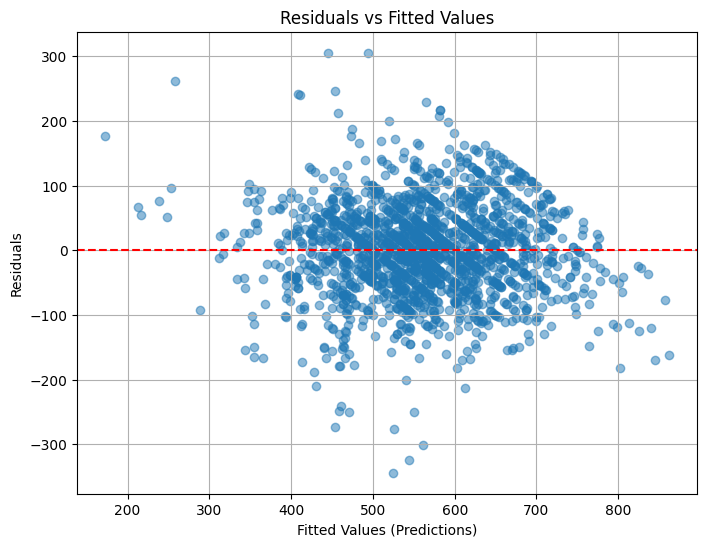

In [108]:
### Residuals vs Fitted Values Plot
predictions = bw_model.transform(test_data).select('prediction').toPandas()

# Calculate residuals (actual - predicted)
residuals = actual_cost['cost'] - predictions['prediction']

# Plot residuals vs fitted values
plt.figure(figsize=(8, 6))
plt.scatter(predictions['prediction'], residuals, alpha=0.5)
plt.axhline(y=0, color='red', linestyle='--')  # Reference line at y=0
plt.title('Residuals vs Fitted Values')
plt.xlabel('Fitted Values (Predictions)')
plt.ylabel('Residuals')
plt.grid()
plt.show()

### Analysis of Residuals vs Fitted Values

This scatter plot displays the residuals (y-axis) versus the fitted (predicted) values (x-axis), with a red dashed horizontal line at zero.

### Observations:
1. **Centering Around Zero**:
    - Most residuals are scattered around the red dashed line at zero, indicating that the model does not show significant bias in over- or under-predictions.

2. **Homoscedasticity Check**:
    - The spread of residuals appears roughly consistent across the range of fitted values, though some slight widening in variance can be observed for larger fitted values (>600). This suggests potential mild heteroscedasticity, but not severe enough to cause concern.

3. **Random Distribution**:
    - There is no clear pattern in the residuals, indicating that the model is not missing a key non-linear relationship. The residuals appear randomly scattered, supporting the assumption of independence in errors.

## TREE MODELS

In [109]:
# Create a VectorAssembler to combine feature columns into a single vector
assembler = VectorAssembler(inputCols=feature_columns, outputCol='features')

# Select the target variable (cost) and prepare the final DataFrame
data = sdf.select('cost', *feature_columns)

# Transform the features into a single vector column
data = assembler.transform(data)

# Create a MinMaxScaler instance
scaler = SparkStandardScaler(inputCol='features', outputCol='scaled_features')

# Fit the scaler to the data
scaler_model = scaler.fit(data)

# Transform the data using the fitted scaler
data = scaler_model.transform(data)

# Split the data into training and test sets
train_data, test_data = data.randomSplit([0.8, 0.2], seed=1003)

In [110]:
# List of number of trees to evaluate
tree_counts = [60, 90, 120]

# Create an empty list to store the results
results = []

# Loop through each tree count, fit the model, and evaluate it
for num_trees in tree_counts:
    # Initialize the Gradient Boosting model with the current number of trees
    gbt = GBTRegressor(featuresCol='scaled_features', labelCol='cost', maxIter=num_trees)

    # Fit the model to the training data
    gbt_model = gbt.fit(train_data)

    # Evaluate the model on the test data
    gbt_predictions = gbt_model.transform(test_data)

    # Save the Gradient Boosting model
    gbt_model.save(f"../models/gbt_model_{num_trees}")

    # Create evaluators for RMSE, MAE, and R-squared
    rmse_evaluator = RegressionEvaluator(labelCol="cost", predictionCol="prediction", metricName="rmse")
    mae_evaluator = RegressionEvaluator(labelCol="cost", predictionCol="prediction", metricName="mae")
    r2_evaluator = RegressionEvaluator(labelCol="cost", predictionCol="prediction", metricName="r2")

    # Evaluate the model on the test data
    gbt_rmse = rmse_evaluator.evaluate(gbt_predictions)
    gbt_mae = mae_evaluator.evaluate(gbt_predictions)
    gbt_r2 = r2_evaluator.evaluate(gbt_predictions)

    # Append the results for this model
    results.append({
        'Number of Trees': num_trees,
        'RMSE (Test)': round(gbt_rmse, 2),
        'MAE (Test)': round(gbt_mae, 2),
        'R^2 (Test)': round(gbt_r2 * 100, 2)  # Convert to percentage
    })

# Convert the results list to a DataFrame for better visibility
results_df = pd.DataFrame(results)

# Display the DataFrame
results_df

24/10/17 22:30:17 WARN DAGScheduler: Broadcasting large task binary with size 1001.5 KiB
24/10/17 22:30:17 WARN DAGScheduler: Broadcasting large task binary with size 1002.0 KiB
24/10/17 22:30:17 WARN DAGScheduler: Broadcasting large task binary with size 1002.5 KiB
24/10/17 22:30:18 WARN DAGScheduler: Broadcasting large task binary with size 1003.7 KiB
24/10/17 22:30:18 WARN DAGScheduler: Broadcasting large task binary with size 1005.9 KiB


,Number of Trees,RMSE (Test),MAE (Test),R^2 (Test)
0,60,62.05,47.17,70.64
1,90,61.47,46.56,71.18
2,120,61.32,46.25,71.33


### Analysis of Gradient Boosting Model with Varying Tree Counts

#### Model Evaluation Metrics
The Gradient Boosting model was evaluated with different numbers of trees to determine the optimal number of trees for the best performance.

| Number of Trees | RMSE (Test) | MAE (Test) | R² (Test) |
|-----------------|-------------|------------|-----------|
| 60              | 62.05       | 47.17      | 70.64%    |
| 90              | 61.47       | 46.56      | 71.18%    |
| 120             | 61.32       | 46.25      | 71.33%    |

#### Key Observations
1. **Root Mean Squared Error (RMSE)**:
    - The RMSE decreases slightly as the number of trees increases from 60 to 120.
    - The lowest RMSE is observed with 120 trees, indicating the model's predictions are closest to the actual values with this configuration.

2. **Mean Absolute Error (MAE)**:
    - Similar to RMSE, the MAE decreases as the number of trees increases.
    - The lowest MAE is also observed with 120 trees, suggesting that the average absolute difference between the predicted and actual values is minimized with this configuration.

3. **R² (Coefficient of Determination)**:
    - The R² value increases as the number of trees increases, indicating that the model explains more variance in the data with more trees.
    - The highest R² value is observed with 120 trees, suggesting that this configuration captures the most variance in the test data.

#### Recommendations
- **Optimal Tree Count**: Based on the evaluation metrics, the model with 120 trees is recommended for the best performance.
- **Further Tuning**: While 120 trees provide the best results among the tested configurations, further tuning of other hyperparameters (e.g., learning rate, max depth) could potentially yield even better performance.
- **Cross-Validation**: To ensure the robustness of the model, consider performing cross-validation with different tree counts and hyperparameters to validate the findings.

In [111]:
# Get feature importances
gbt_feature_importances = gbt_model.featureImportances

# Create a DataFrame from the feature importances
feature_importances_df = pd.DataFrame({
    'feature': feature_columns,
    'importance': gbt_feature_importances.toArray()
})

# Sort the DataFrame by the 'importance' column in decreasing order
feature_importances_df = feature_importances_df.sort_values(by='importance', ascending=False)
feature_importances_df.head(10)

,feature,importance
1,beds,0.156847
2,baths,0.044326
0,postal_code,0.034246
52,cbd_average_travel_distance_kms,0.033304
29,prop_type_index,0.032919
185,increase_2010_pop,0.027633
140,sep_2020,0.025671
152,median_inc,0.023730
35,schools_average_travel_time_mins,0.021538
53,cbd_time_distance_product,0.020926


#### Key Observations
1. **Beds**: The number of beds is the most important feature, with an importance score of 0.156847. This suggests that the number of beds in a property is a strong predictor of its cost.
2. **Baths**: The number of baths is also a significant feature, with an importance score of 0.044326.
3. **Postal Code**: The postal code has an importance score of 0.034246, indicating that the location of the property is an important factor in determining its cost.
4. **Travel Distance to CBD**: Features related to the average travel distance to the central business district (CBD) and the time-distance product are important, with scores of 0.033304 and 0.020926, respectively.
5. **Property Type**: The property type index has an importance score of 0.032919, suggesting that the type of property is a relevant factor.
6. **Population Increase**: The increase in population in 2010 has an importance score of 0.027633, indicating its relevance in predicting property cost.
7. **Monthly Data**: The feature `sep_2020` has an importance score of 0.025671, suggesting that there may be temporal effects influencing property values.
8. **Median Income**: The median income has an importance score of 0.023730, indicating its impact on property cost.
9. **School Travel Time**: The average travel time to schools has an importance score of 0.021538, suggesting its relevance in the model.

In [112]:
# from sklearn.preprocessing import StandardScaler

# # Read the data from the Parquet file
# sdf = spark.read.parquet("../data/curated/prop_cleaned2.parquet")

# # Convert Spark DataFrame to Pandas DataFrame
# pandas_df = sdf.toPandas()

# # Define feature columns and target variable
# feature_columns = [col for col in pandas_df.columns if col not in ['name', 'property_url', 'cost', 'affordability_score', 'combined_score']]
# X = pandas_df[feature_columns]
# y = pandas_df['cost']

# # Split the data into train and test sets
# from sklearn.model_selection import train_test_split
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # Scale the features using StandardScaler
# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)

In [113]:
# import sys
# sys.setrecursionlimit(10000)
# from tensorflow import keras
# from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# # Define a simple Neural Network model using Keras
# def create_neural_network(input_shape):
#     model = keras.Sequential([
#         keras.layers.Dense(64, activation='relu', input_shape=input_shape),
#         keras.layers.Dense(64, activation='relu'),
#         keras.layers.Dense(1)  # Output layer for regression
#     ])
    
#     # Compile the model with appropriate loss and optimizer
#     model.compile(optimizer='adam', loss='mse', metrics=['mae'])
#     return model

# # Create the neural network model
# nn_model = create_neural_network((X_train_scaled.shape[1],))

# # Train the model
# history = nn_model.fit(X_train_scaled, y_train, epochs=120, batch_size=32, validation_split=0.5, verbose=1)

# # Predict on test data
# y_pred_nn = nn_model.predict(X_test_scaled).flatten()

# # Calculate metrics
# nn_rmse = mean_squared_error(y_test, y_pred_nn, squared=False)
# nn_mae = mean_absolute_error(y_test, y_pred_nn)
# nn_r2 = r2_score(y_test, y_pred_nn)

# # Print evaluation metrics
# print(f"Neural Network RMSE: ${nn_rmse:.2f}")
# print(f"Neural Network MAE: ${nn_mae:.2f}")
# print(f"Neural Network R²: {nn_r2 * 100:.2f}%")

In [114]:
spark.stop()